# K-Means Clustering - Overview

## Introduction
K-Means is an **unsupervised machine learning algorithm** used for clustering data into groups based on feature similarity.  
It is widely applied in market segmentation, image compression, anomaly detection, and more.

---

## Key Concepts
- **Cluster**: A group of similar data points.
- **Centroid**: The center of a cluster, calculated as the mean of all points in the cluster.
- **K**: The number of clusters the algorithm divides the data into (chosen beforehand).

---

## How K-Means Works
1. **Initialize**: Choose `K` centroids randomly.
2. **Assign**: Assign each data point to the nearest centroid (forming clusters).
3. **Update**: Recalculate centroids as the mean of all points in each cluster.
4. **Repeat**: Continue assigning and updating until centroids stabilize (no significant change).

---

## Choosing K
- **Elbow Method**: Plot inertia (within-cluster sum of squared errors) vs. `K` and look for the "elbow" point.
- **Silhouette Score**: Measures how similar an object is to its cluster compared to other clusters.

---

## Advantages
- Simple and easy to implement.
- Works well with large datasets.
- Efficient and fast.

---

## Limitations
- Must specify `K` in advance.
- Sensitive to outliers and noisy data.
- Assumes clusters are spherical and evenly sized.
- Results can vary based on initial centroid selection.

---

## Applications
- Customer segmentation in marketing.
- Document or text clustering.
- Image compression.
- Anomaly detection.

---


Elbow candidates: [3, 3, 2] -> chosen (majority): k=3
Best k by Silhouette: k=2 (score=0.552)


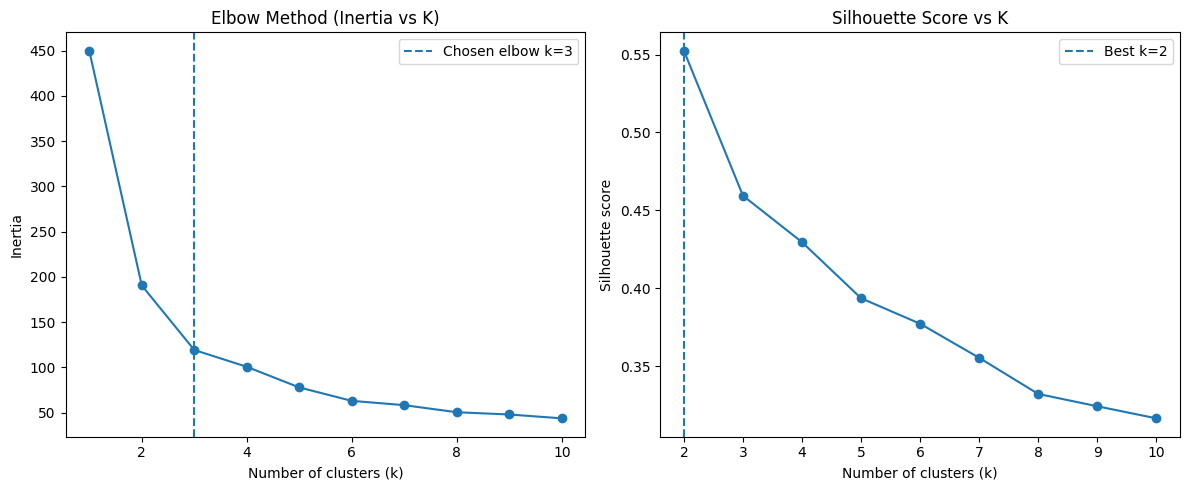

In [10]:

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ---- optional: KneeLocator (handled gracefully if missing)
try:
    from kneed import KneeLocator
    HAS_KNEE = True
except Exception:
    HAS_KNEE = False

# ---- data
iris = load_iris()
X = iris.data[:, :3]  # use sepal_length & sepal_width to match your setup
X = StandardScaler().fit_transform(X)  # scaling helps KMeans distance behavior

# ---- helpers
def make_kmeans(k):
    # Compatible with scikit-learn versions old/new
    try:
        return KMeans(n_clusters=k, n_init="auto", random_state=42)
    except TypeError:
        return KMeans(n_clusters=k, n_init=10, random_state=42)

def elbow_by_max_distance_to_line(Ks, inertias):
    k = np.array(list(Ks), dtype=float)
    y = np.array(inertias, dtype=float)
    x1, y1 = k[0], y[0]
    x2, y2 = k[-1], y[-1]
    # perpendicular distance from each (k, y) to the line between endpoints
    distances = np.abs((y2 - y1) * k - (x2 - x1) * y + x2 * y1 - y2 * x1) / np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
    return int(k[np.argmax(distances)])

def elbow_by_second_derivative(Ks, inertias):
    y = np.array(inertias, dtype=float)
    # discrete second derivative
    d2 = y[:-2] - 2 * y[1:-1] + y[2:]
    idx = int(np.argmax(d2)) + 1  # +1 because d2 aligns with Ks[1:-1]
    return list(Ks)[idx]

# ---- grid of K values
K_elbow = range(1, 11)   # inertia can be computed from k=1
K_sil   = range(2, 11)   # silhouette is defined for k>=2

inertia = []
for k in K_elbow:
    km = make_kmeans(k)
    km.fit(X)
    inertia.append(km.inertia_)

silhouette_scores = []
for k in K_sil:
    km = make_kmeans(k)
    labels = km.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

# ---- elbow: multiple estimators (with fallbacks)
candidates = []

# 1) KneeLocator (if available)
if HAS_KNEE:
    kneedle = KneeLocator(list(K_elbow), inertia, curve="convex", direction="decreasing")
    if kneedle.knee is not None:
        candidates.append(int(kneedle.knee))

# 2) Max distance to chord
candidates.append(elbow_by_max_distance_to_line(K_elbow, inertia))

# 3) Second derivative
candidates.append(elbow_by_second_derivative(K_elbow, inertia))

# majority vote among elbow candidates
vote = Counter(candidates)
best_k_elbow = vote.most_common(1)[0][0]

# ---- silhouette best k
best_k_silhouette = list(K_sil)[int(np.argmax(silhouette_scores))]

print(f"Elbow candidates: {candidates} -> chosen (majority): k={best_k_elbow}")
print(f"Best k by Silhouette: k={best_k_silhouette} (score={max(silhouette_scores):.3f})")

# ---- plots
plt.figure(figsize=(12, 5))

# Elbow / inertia
plt.subplot(1, 2, 1)
plt.plot(list(K_elbow), inertia, marker='o')
plt.axvline(best_k_elbow, linestyle='--', label=f'Chosen elbow k={best_k_elbow}')
# also show KneeLocator knee if different and available
if HAS_KNEE and kneedle.knee is not None and int(kneedle.knee) != best_k_elbow:
    plt.axvline(int(kneedle.knee), linestyle=':', label=f'KneeLocator k={int(kneedle.knee)}')
plt.title('Elbow Method (Inertia vs K)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.legend()

# Silhouette
plt.subplot(1, 2, 2)
plt.plot(list(K_sil), silhouette_scores, marker='o')
plt.axvline(best_k_silhouette, linestyle='--', label=f'Best k={best_k_silhouette}')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.legend()

plt.tight_layout()
plt.show()

# ---- (optional) if you want a single recommended k:
# recommended_k = best_k_elbow if best_k_elbow == best_k_silhouette else best_k_silhouette
# print("Recommended k:", recommended_k)
